# Vector Auto-regressive Models Applied to Interest Rates

We will consider the joint dynamics of the weekly observations of interest rates on the one-, three- and six-month Eurodollar deposits. Source of the data: Federal Reserve of the USA

Testing the levels of these series reveals that they are all integreated of order 1 so we need to work out the stationary differences.

In [3]:
library(readxl)
library(vars)
library(timeSeries)

euro_dollar_rates <- read_excel("./Module_5_Data_Euro-Dollar_Rates.xls", sheet = "Weekly,_Ending_Friday")
head(euro_dollar_rates)

DATE,WED1,WED3,WED6
<dttm>,<dbl>,<dbl>,<dbl>
1989-12-29,8.56,8.33,8.19
1990-01-05,8.25,8.25,8.17
1990-01-12,8.19,8.19,8.16
1990-01-19,8.19,8.20,8.25
1990-01-26,8.20,8.25,8.31
1990-02-02,8.19,8.25,8.31


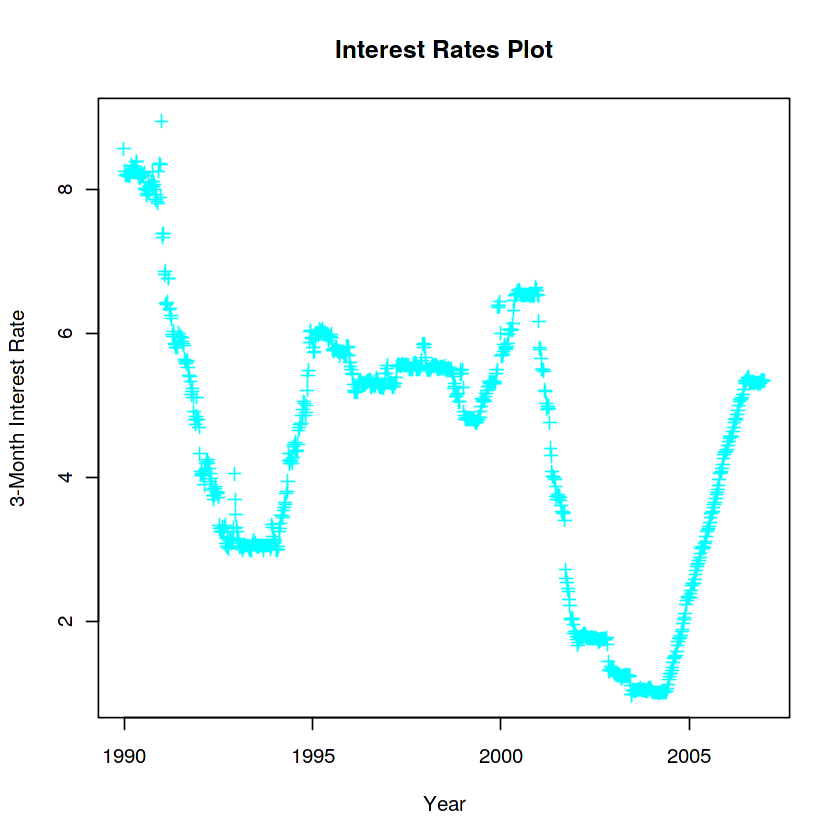

In [4]:
plot(euro_dollar_rates$WED1 ~ euro_dollar_rates$DATE, pch = 3, col = "cyan", xlab = "Year", ylab = "3-Month Interest Rate")
title("Interest Rates Plot")

Find changes in interest rates by differencing:

In [6]:
d_one_month_rate <- diff(euro_dollar_rates$WED1, trim = TRUE)
d_three_month_rate <- diff(euro_dollar_rates$WED3, trim = TRUE)
d_six_month_rate <- diff(euro_dollar_rates$WED6, trim = TRUE)

d_rates <- cbind(d_one_month_rate, d_three_month_rate, d_six_month_rate)

Calculate simple correlations

In [7]:
cor(d_rates)

,d_one_month_rate,d_three_month_rate,d_six_month_rate
d_one_month_rate,1.0000000,0.7796145,0.6691881
d_three_month_rate,0.7796145,1.0000000,0.9073374
d_six_month_rate,0.6691881,0.9073374,1.0000000


The simple contemporaneous corrletaions show that there are strong correlations in the changes in these interest rates, which makes sense from an economic point of view as they are just of different maturities on the same interest rate.

**Estimate a Vector Auto Regression:**
The appropriate lag length is determined automatically by the following command:

In [9]:
VAR_model <- VAR(d_rates, lag.max=12, type = "none", ic = "AIC")
summary(VAR_model)


VAR Estimation Results:
Endogenous variables: d_one_month_rate, d_three_month_rate, d_six_month_rate 
Deterministic variables: none 
Sample size: 878 
Log Likelihood: 3957.243 
Roots of the characteristic polynomial:
0.8873 0.8873 0.8829 0.8641 0.8641 0.8448 0.8448 0.8398 0.8398 0.8252 0.8252 0.8202 0.8202 0.8167 0.8167 0.8066 0.8066 0.7475 0.7475 0.7349 0.7349 0.7228 0.7228 0.6854 0.3642 0.3642 0.2806
Call:
VAR(y = d_rates, type = "none", lag.max = 12, ic = "AIC")


Estimation results for equation d_one_month_rate: 
d_one_month_rate = d_one_month_rate.l1 + d_three_month_rate.l1 + d_six_month_rate.l1 + d_one_month_rate.l2 + d_three_month_rate.l2 + d_six_month_rate.l2 + d_one_month_rate.l3 + d_three_month_rate.l3 + d_six_month_rate.l3 + d_one_month_rate.l4 + d_three_month_rate.l4 + d_six_month_rate.l4 + d_one_month_rate.l5 + d_three_month_rate.l5 + d_six_month_rate.l5 + d_one_month_rate.l6 + d_three_month_rate.l6 + d_six_month_rate.l6 + d_one_month_rate.l7 + d_three_month_rate.l7 + d_s

## Interpretation

Given the many coefficients, the simplest method to interpret what this estimation means for the dynamics of these variables i sto use two standard tools:

### 1. Impulse Response Function

Answers the following question: Suppose the system starts in long run equilibrium, i.e. all variables are at their unconditional expected values ($E[Y_t] = \mu$). Suppose there is now a 1 SD increase in error i. What is the dynamic path of each of the variables in their return to long-run equilibrium?

We have: 3 variables with 3 errors ==> there are 9 impulse response functions

To construct these, one must make an untestable assumption about the contemporaneous effects among the variables, i.e. identification assumptions.

The Cholesky decomposition will be used as our standard identification choice.

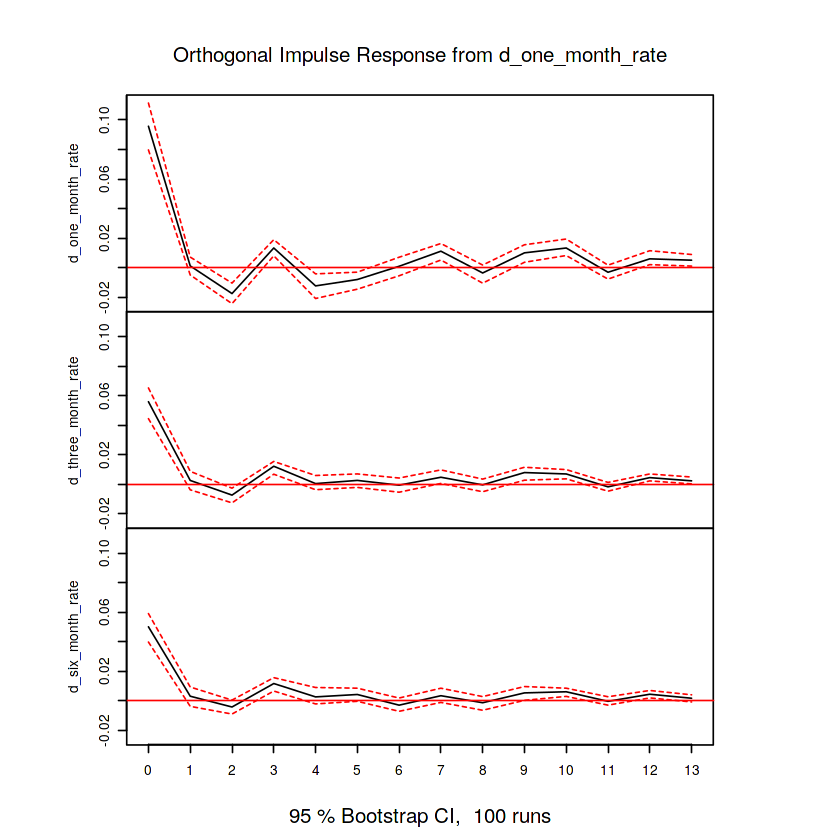

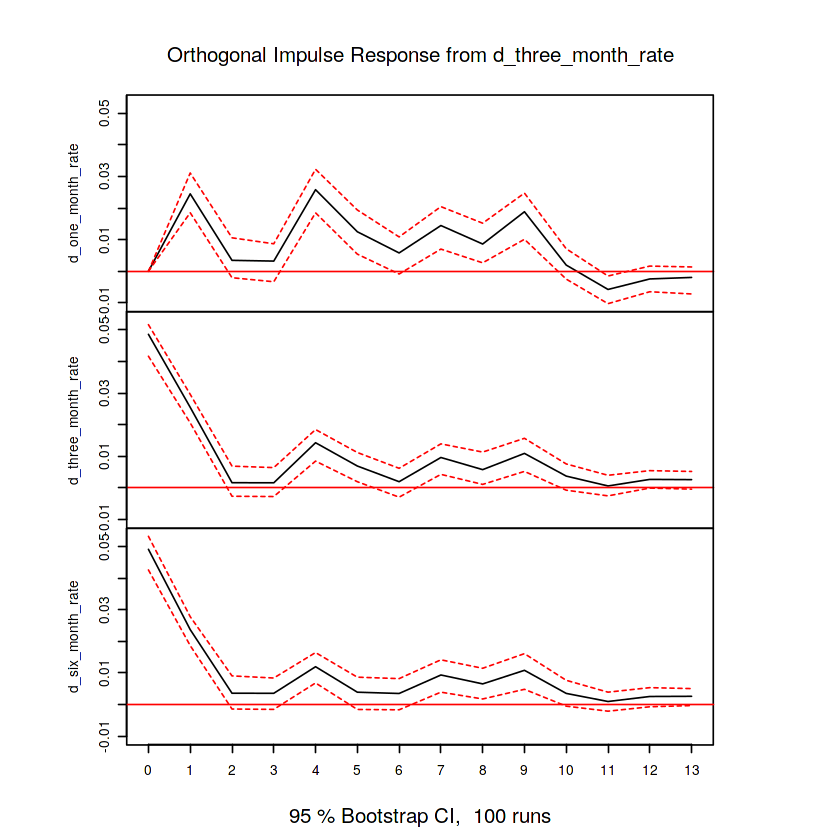

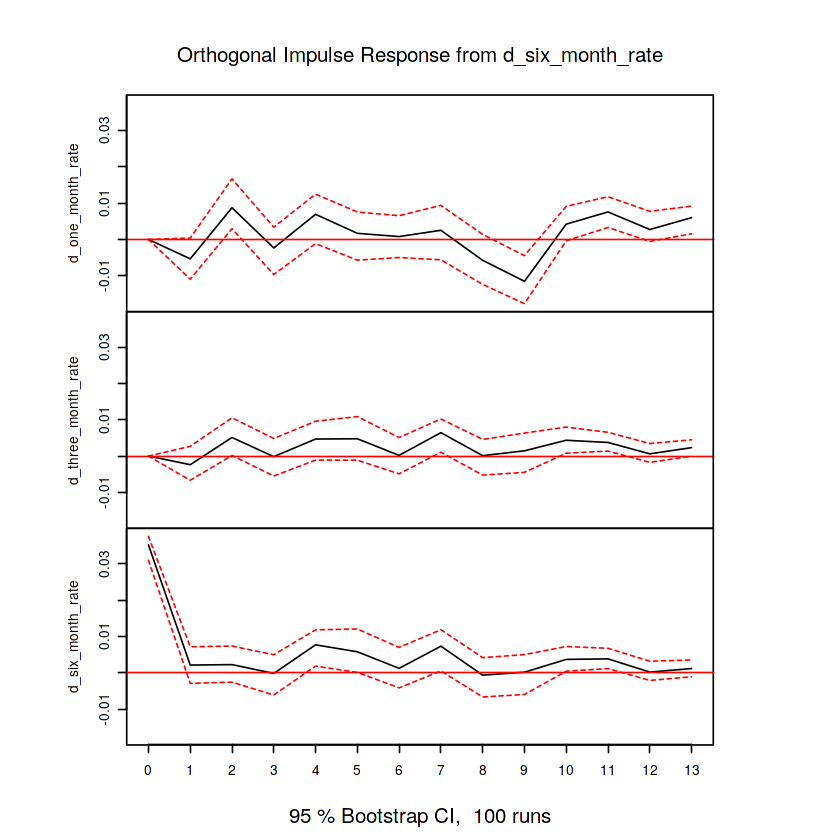

In [10]:
VAR_irf <- irf(VAR_model, n.ahead = 13, boot=TRUE, ci=0.95)
plot(VAR_irf)

Each of the combined graphs represent a shock to the specific innovation. The rows of each graph represent the responses of each variable to that shock.

Red line is the long-term mean.

**1st Graph:**

By definition a variable responds immediately to its own innovation and in this case th impact fades out quite quickly but oscillates around its mean in a dampening pattern for about 13 weeks.

The response of the 3 and 6 month interest rate is also large but slightly smaller in the first period and follows a similiar oscillatory return to the mean.

**2nd Graph:**

An innovation to 3-month interest rates has no impact on the 1-month interest rates due to our Cholesky decomposition assumption. In 2nd to 9th period there is some evidence that the DWED3 unexpected increase has some positive impact of DWED3.

### 2. Forecast Variance Decomposition

Answers the question for each forecast horizon form 1 tpo h: how much of the forecast error variance is due to the shock in each equation?

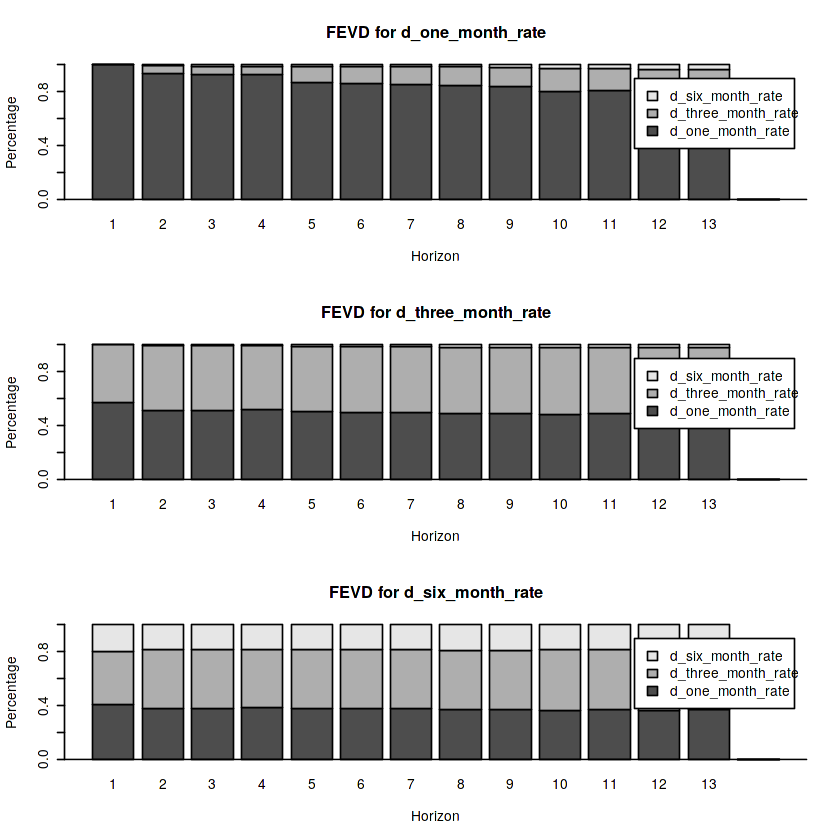

In [12]:
VAR_fevd <- fevd(VAR_model, n.ahead=13)
plot(VAR_fevd)

The FEV of DWED1 is initially entirely explained by only its own innovations but by 13 weeks the innovations to DWED3 explain 20% of its variance.

The FEV of DWED6 looks completely different instead. In the 1st period its innovations only explain 20% of the forecast variance. It is thus critical to jointly forecast (in this estimated model) all three of these variables to obtain good forecasts of DWED6.

## Evaluation:

### 1. Stationarity:

All the roots of the characteristic polynomial are inside the unit circle therefore we conclude that the series in stationary.

### 2. Parsimony:

Looking at the full output, there are many insignificant coefficients at different horizons an in different equations in the model. However, if we were to restrict these individually to zero and re-estimate the model, it would imply that one is imposing a specific, arbitrary structure on the endogenous joint evolution of the process without strong *a priori economiv reasons*.

**Lag Restriction test:**

In the VAR models we can however consider removing either a variable from the model (e.g. exclude one of the return series) or reducing the lag structure of the whole model.

i.e. if one did an F-Test that all nine of the eighth lag coefficients were jointly insignificant and did not reject, one could validly make the model more parsimonious by moving to a VAR(7) model.

**Does the model encompass the DGP?**

A critical aspect of an acceptable model is that it is encompassing (there must be no time series information in the residuals).

Since we have four of these residual series we testing each of the residuals for auto-correlation is not sufficient. Also, there must be no cross-correlation between the past of each residual series in the present realization. 

A useful tool is the auto-correlogram and cross-correlogram.

In [19]:
# Obtain Residuals

resids <- residuals(VAR_model)
resid_1 <- resids[,1]
resid_2 <- resids[,2]

head(resids)

,d_one_month_rate,d_three_month_rate,d_six_month_rate
1,0.01497829,0.06175650,0.10918514
2,0.09811432,0.11321953,0.16968030
3,-0.03274587,-0.10607021,-0.11423492
4,-0.01687823,0.01518146,0.01334699
5,-0.02243549,-0.02276818,0.07267442
6,-0.05212778,-0.03964122,-0.21011167


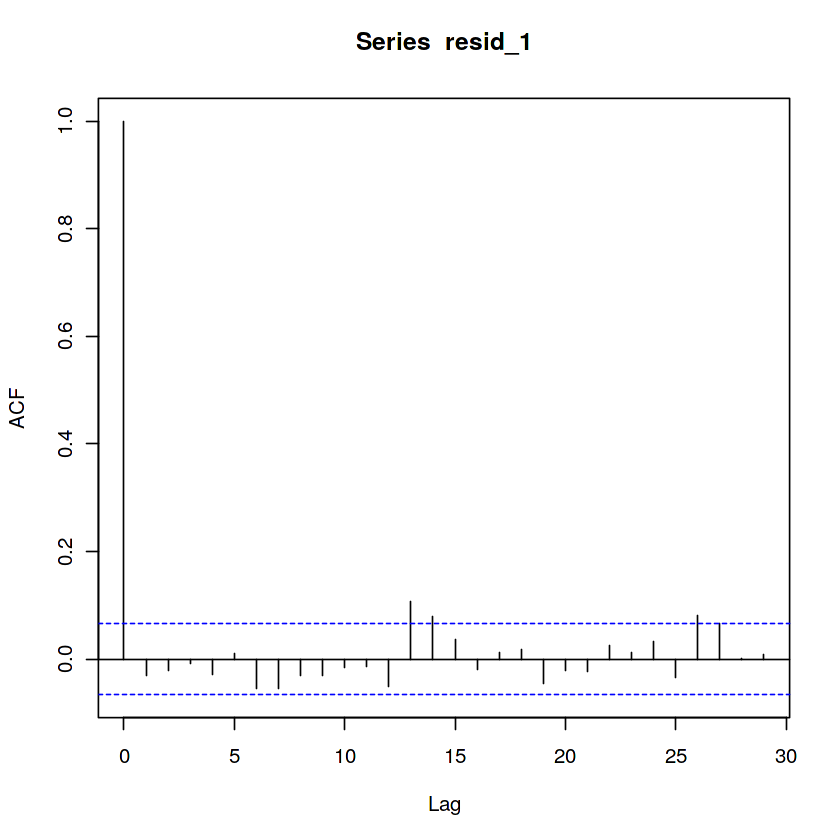

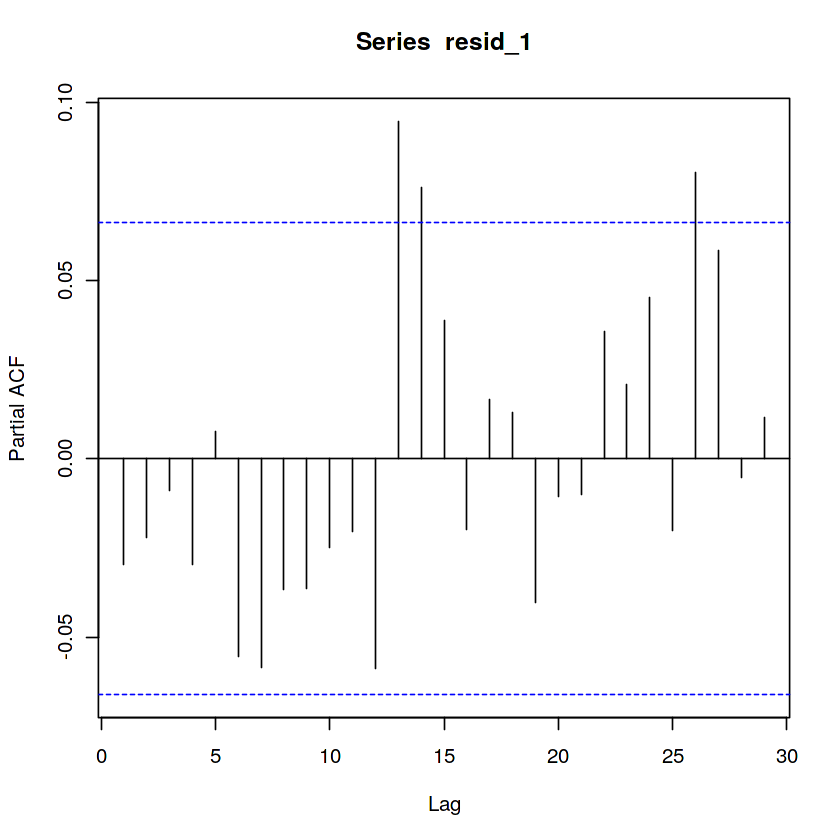

In [25]:
acf(resid_1)
pacf(resid_1)

The ACF and PACF of the residuals of the first equation which are all non-significant.

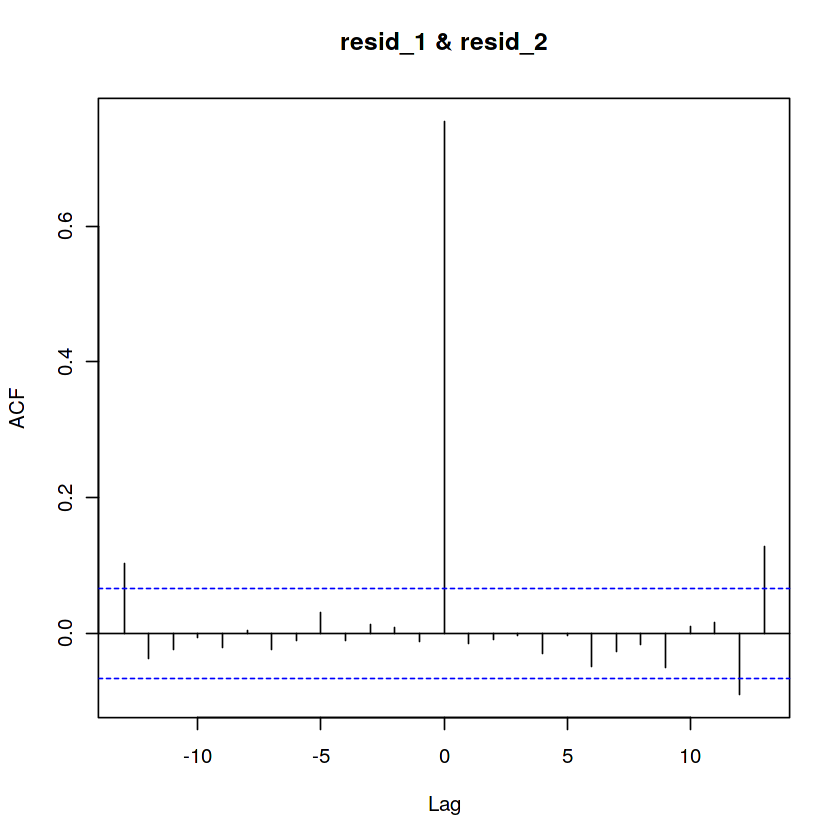

In [20]:
# View cross correlogram

ccf(resid_1, resid_2, lag.max=13, type = "correlation", plot = TRUE)

There are strong contemporaneous correlations which is standard in residuals and what the identification problem is built on disentangling. There is also significnat correlation at long lags. It is not immediately obvious if this is systematic. 

Sampling variation will always yield one or two spuriously significant correlations so sound judgement is advised when concluding whether a VAR modle is encompassing the DGP of interest.